In [1]:
#This is a code written to make one familiar with a component of Qiskit known as Ignis. So far, people normally use Aqua to get algorithsm, Terra to create circuits and Aer to simulate them. 
from qiskit import *

In [2]:
circuit = QuantumCircuit(3, 3)
circuit.h(0)
circuit.cx(0, 1)
circuit.cx(1, 2)
circuit.measure([0,1,2], [0,1,2])

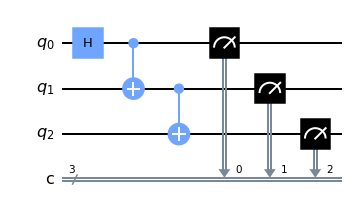

In [3]:
%matplotlib inline
circuit.draw(output = 'mpl')

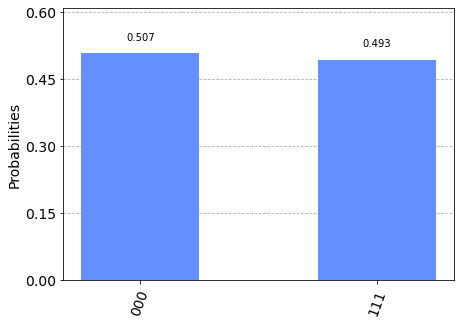

In [6]:
from qiskit.visualization import plot_histogram
sim = Aer.get_backend('qasm_simulator')
result = execute(circuit, backend = sim, shots = 1000).result()
plot_histogram(result.get_counts(circuit))

In [7]:
#Now, we know that on a real QC, there will be some errors which account for the noise error and other errors presently present in QC
#This step entails running the circuit on a real QC. 
IBMQ.load_account()
provider = IBMQ.get_provider(hub = 'ibm-q')
device = provider.get_backend('ibmq_quito')

job = execute(circuit, backend = device, shots = 1000)

from qiskit.tools.monitor import job_monitor
job_monitor(job)

Job Status: job has successfully run


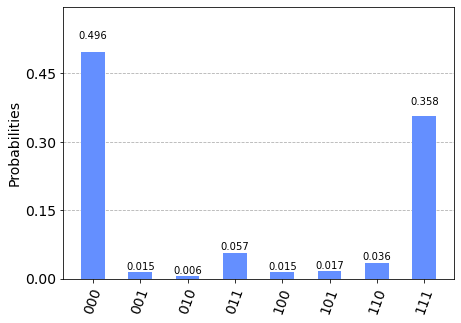

In [9]:
qc_result = job.result()
plot_histogram(qc_result.get_counts(circuit))

In [10]:
#Now, as we can see in the histogram, there are vast errors that keep us from getting the actual 000 and 111 values, as an ideal QC would. Here is where Ignis comes to play
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)

In [16]:
cal_circuits, state_labels = complete_meas_cal(qr = circuit.qregs[0], circlabel = 'measuretheerror')

In [18]:
#Ignis has given a series of cal circuits to run to find the errors in all of the circuits( 8 as we have 3 bits)
len(cal_circuits)

8

In [19]:
cal_job = execute(cal_circuits, backend = device, shots = 1000, optimization_level = 0 )
#Optimizationlevels make sure that the circuit is not optimized as we send the code from here to an actual QC.
job_monitor(cal_job)

Job Status: job has successfully run


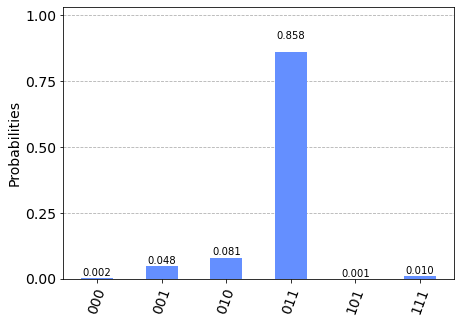

In [23]:
cal_res = cal_job.result()
plot_histogram(cal_res.get_counts(cal_circuits[3]))


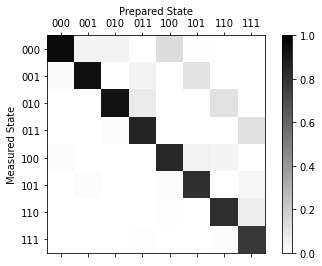

In [24]:
#This is where we create a fitter. 
meas_fitter = CompleteMeasFitter(cal_res, state_labels)
meas_fitter.plot_calibration()

#this will show the largest number of results (states) created. 

In [28]:
#Now we create the filter. 
meas_filter = meas_fitter.filter
opt_res = meas_filter.apply(qc_result)
device_counts = qc_result.get_counts(circuit)
opt_counts = opt_res.get_counts(circuit)

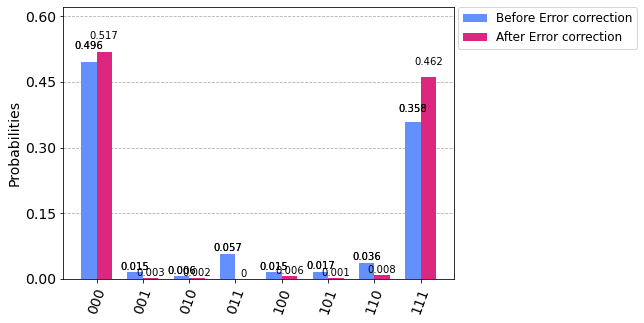

In [29]:
plot_histogram([device_counts, opt_counts], legend = ['Before Error correction', 'After Error correction'])


In [ ]:
#As we can see here, the errors after the optimization and filter application have dissapeared. 